In [1]:
import numpy as np
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy import stats
from numpy.linalg import inv

from matplotlib import pyplot as plt
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

from datetime import datetime
months =[datetime(2019, imon, 1) for imon in np.arange(1,12+1)]
month_str = [date_obj.strftime('%b') for date_obj in months]
m_str = [w[0] for w in month_str];

# Get color order
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

In [2]:
def cor(x,y):
    xa = x - np.nanmean(x)
    ya = y - np.nanmean(y)
    return np.nansum(xa*ya)/np.sqrt(np.nansum(xa**2)*np.nansum(ya**2))

<h1><center>Periodic AR2 model Nino 3.4 fitting performance analysis</center></h1>

### Background

Nino 3.4 is an important quantity. As an ENSO status indicator it connects to many other weather variables such as precipitation. Being able to accurately model Nino 3.4 is meaningful to understand how global weather pattern varies in a short lead time. Jin et al. [1] studied Nino 3.4 modeling in the framework of an autogressive model focusing on the seasonal persistence barrier. In homework 8 [2], we attempted to simulate Nino 3.4 anomaly with periodic AR1 model. Here I expand previous work by modeling Nino 3.4 with period AR2 model and analyze this model's performance in terms of sample variance and correlation modeling capaticity. Besides, periodic AR2's performance is compared to periodic AR1's to see to what extent Nino 3.4 modeling can be improved by incorporating extra previous time steps' Nino 3.4 information. 

### Data and methods

#### 1. Dataset

The Nino 3.4 dataset used in this project is a monthly dataset with temporal extent from 1980 to 2020. To simplify modeling process, dataset's monthly average is removed, which gives Nino 3.4 anomaly. As demonstrated by the code below: 

In [3]:
n34_url = 'http://iridl.ldeo.columbia.edu/home/.tippett/.scratch/.APMA4990/.n34/dods'
n34_ds = xr.open_dataset(n34_url)
n34 = n34_ds.n34
nmonths = len(n34)
n34a = n34.groupby('T.month') - n34.groupby('T.month').mean()

#### 2. Analysis

To fit to Nino 3.4 anomaly, a periodic AR2 model with mean 0 is defined: 

$$X_t = \phi_1(t) X_{t-1} + \phi_2(t) X_{t-2} + W_t,$$ 

where $X_t$ is Nino 3.4 anomaly at $t$ th time step. $W_t$ is a periodic Gaussian noise term with $W_t \sim N(0, \sigma_t^2)$ and $\sigma_t = \sigma_{t+12}$. In addition,
$\phi_1(t)$ and $\phi_2(t)$ are periodic coefficients with a period of 12 meaning $\phi_1(t) = \phi_1(t + 12)$ and $\phi_2(t) = \phi_2(t+12)$. To be more specific, they are formulated as: 

$$\phi_1(t) = a_0 + a_1 \sin( 2 \pi t /12) + b_1 \cos( 2 \pi t/12)$$
$$\phi_2(t) = c_0 + d_1 \sin( 2 \pi t /12) + e_1 \cos( 2 \pi t/12)$$

In this project, model's fitting performance is evaluated by how close the model variance and correlation are to the sample variance and correlation. To arrive at model correlation, model variance and covariance derivation are first shown below.

##### 2.1 Model variance

By time shifting, $X_t = \phi_1(t) X_{t-1} + \phi_2(t) X_{t-2} + W_t$ gives:

$$ X_{t+2} = \phi_1(t+2) X_{t+1} + \phi_2(t+2) X_{t} + W_{t+2}\ \ \     (1)$$

Take the variance of both sides of equation 1:

$$ \text{Var}[X_{t+2}] = \text{Var}[\phi_1(t+2) X_{t+1} + \phi_2(t+2) X_{t} + W_{t+2} ]$$
$$ \phi_2^2(t+2) \text{Var}[X_{t}] + \phi_1^2(t+2) \text{Var}[X_{t+1}] - \text{Var}[X_{t+2}] + 2\phi_1(t+2)\phi_2(t+2)\text{Cov}[X_{t},X_{t+1}] = - \sigma_{t+2}^{2}\ \ \     (2)$$

Multiply both sides of equation 1 by $X_{t+1}$ and take expectation:

$$ X_{t+2}X_{t+1} = \phi_1(t+2) X^2_{t+1} + \phi_2(t+2) X_{t} X_{t+1}+ W_{t+2} X_{t+1}$$
$$ \phi_1(t+2)\text{Var}[X_{t+1}] + \phi_2(t+2)\text{Cov}[X_{t}, X_{t+1}] - \text{Cov}[X_{t+1}, X_{t+2}] = 0\ \ \     (3)$$

By applying time shifting on equations 2 and 3, we can construct a system of equations written as $ A_t v_t = b_t$ to solve for model variance, where $v_t$ and $b_t$ are vectors defined as:

$$v_t = \{\text{Var}[X_t], \cdots, \text{Var}[X_{t+11}], \text{Cov}[X_t, X_{t+1}], \cdots, \text{Cov}[X_{t+11}, X_{t+12}]\}$$
$$ b_t = \{ - \sigma_{t+2}^{2}, \cdots, - \sigma_{t+13}^{2}\, 0, \cdots, 0\} $$

$A_t$ is a matrix given by:

$$
\begin{bmatrix}
\phi_2^2(t+2) & \phi_1^2(t+2) & -1 & 0 & 0 & \cdots & 0 & 0 & 0 & 2\phi_1(t+2)\phi_2(t+2) & 0 & 0 & \cdots & 0 & 0 & 0\\
0 & \phi_2^2(t+3) & \phi_1^2(t+3) & -1 & 0 & \cdots & 0 & 0 & 0 & 0 & 2\phi_1(t+3)\phi_2(t+3) & 0 & \cdots & 0 & 0 & 0\\
0 & 0 & \phi_2^2(t+4) & \phi_1^2(t+4) & -1 & \cdots & 0 & 0 & 0 & 0 & 0 & 2\phi_1(t+4)\phi_2(t+4) & \cdots & 0 & 0 & 0\\
\vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots\\
0 & 0 & 0 & 0 & 0 & \cdots & \phi_2^2(t+11) & \phi_1^2(t+11) & -1 & 0 & 0 & 0 & \cdots & 2\phi_1(t+11)\phi_2(t+11) & 0 & 0 \\
-1 & 0 & 0 & 0 & 0 & \cdots & 0 & \phi_2^2(t+12) & \phi_1^2(t+12) & 0 & 0 & 0 & \cdots & 0 & 2\phi_1(t+12)\phi_2(t+12) & 0 \\
\phi_1^2(t+13) & -1 & 0 & 0 & 0 & \cdots & 0 & 0 & \phi_2^2(t+13) & 0 & 0 & 0 & \cdots & 0 & 0 & 2\phi_1(t+13)\phi_2(t+13) \\
0 & \phi_1(t+2) & 0 & 0 & 0 & \cdots & 0 & 0 & 0 & \phi_2(t+2) & -1 & 0 & \cdots & 0 & 0 & 0 \\
0 & 0 & \phi_1(t+3) & 0 & 0 & \cdots & 0 & 0 & 0 & 0 & \phi_2(t+3) & -1 & \cdots & 0 & 0 & 0 \\
\vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots\\
0 & 0 & 0 & 0 & 0 & \cdots & 0 & 0 & \phi_1(t+12) &  0 & 0 & 0 & \cdots & 0 & \phi_2(t+12) & -1 \\
\phi_1(t+13) & 0 & 0 & 0 & 0 & \cdots & 0 & 0 & 0 & -1 & 0 & 0 & \cdots & 0 & 0 & \phi_2(t+13)\\
\end{bmatrix}
$$


Solve this system of equations: $v_t = A_{t}^{-1}b_t$. The first 12 elements of $v_t$ give the model variance and the last 12 elements give model covariance of lead time of 1.

##### 2.2 Model covariance

In order to solve for correlation, covariance needs to be solved first. So here another system of equations is constructed with unknowns represented as a vector:

$$ c_t = \{\text{Cov}[X_{t}, X_{t+2}], \text{Cov}[X_{t}, X_{t+3}], \cdots, \text{Cov}[X_{t}, X_{t+11}], \text{Cov}[X_{t}, X_{t+12}]\} $$

The same as before, we start from $X_{t+2} = \phi_1(t+2) X_{t+1} + \phi_2(t+2) X_{t} + W_{t+2}$. Multiply both sides by $X_t$ and take expectation, which gives:

$$ \text{Cov}[X_{t}, X_{t+2}] = \phi_1(t+2) \text{Cov}[X_{t}, X_{t+1}] + \phi_2(t+2) \text{Var}[X_{t}] $$

Then we do the same operation but to $ X_{t+3} = \phi_1(t+3) X_{t+2} + \phi_2(t+3) X_{t+1} + W_{t+3} $. So we have:

$$ \text{Cov}[X_{t}, X_{t+3}] = \phi_1(t+3) \text{Cov}[X_{t}, X_{t+2}] + \phi_2(t+3) \text{Cov}[X_{t}, X_{t+1}]$$

Similarly, we can obtain:

$$ \text{Cov}[X_{t}, X_{t+4}] = \phi_1(t+4) \text{Cov}[X_{t}, X_{t+3}] + \phi_2(t+4) \text{Cov}[X_{t}, X_{t+2}] $$
$$ \text{Cov}[X_{t}, X_{t+5}] = \phi_1(t+5) \text{Cov}[X_{t}, X_{t+4}] + \phi_2(t+5) \text{Cov}[X_{t}, X_{t+3}] $$
$$ \cdots $$
$$ \text{Cov}[X_{t}, X_{t+12}] = \phi_1(t+12) \text{Cov}[X_{t}, X_{t+11}] + \phi_2(t+12) \text{Cov}[X_{t}, X_{t+10}] $$

By reorganizing these equations, we have:

$$  - \text{Cov}[X_{t}, X_{t+2}]= - \phi_1(t+2) \text{Cov}[X_{t}, X_{t+1}] - \phi_2(t+2) \text{Var}[X_{t}]$$
$$ \phi_1(t+3) \text{Cov}[X_{t}, X_{t+2}] - \text{Cov}[X_{t}, X_{t+3}] = - \phi_2(t+3) \text{Cov}[X_{t}, X_{t+1}] $$
$$ \phi_2(t+4) \text{Cov}[X_{t}, X_{t+2}] + \phi_1(t+4) \text{Cov}[X_{t}, X_{t+3}]  - \text{Cov}[X_{t}, X_{t+4}] = 0 $$
$$ \phi_2(t+5) \text{Cov}[X_{t}, X_{t+3}] + \phi_1(t+5) \text{Cov}[X_{t}, X_{t+4}]  - \text{Cov}[X_{t}, X_{t+5}] = 0 $$
$$ \cdots $$
$$ \phi_2(t+12) \text{Cov}[X_{t}, X_{t+10}] + \phi_1(t+12) \text{Cov}[X_{t}, X_{t+11}] - \text{Cov}[X_{t}, X_{t+12}] =  0$$

When writting these equations in matrix format: $B_{t}c_{t}=d_{t}$, it gives:

$$ B_t = 
\begin{bmatrix}
-1 & 0 & 0 & 0 & \cdots & 0 & 0 & 0\\
\phi_1(t+3) & -1 & 0 & 0 & \cdots & 0 & 0 & 0\\
\phi_2(t+4) & \phi_1(t+4) & -1 & 0 & \cdots & 0 & 0 & 0\\
0 & \phi_2(t+5) & \phi_1(t+5) &  -1 & \cdots & 0 & 0 & 0\\
\vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots\\
0 & 0 & 0 & 0 & \cdots & \phi_2(t+12) & \phi_1(t+12) & -1\\
\end{bmatrix}
$$

$$d_t = \{- \phi_1(t+2) \text{Cov}[X_{t}, X_{t+1}] - \phi_2(t+2) \text{Var}[X_{t}], - \phi_2(t+3) \text{Cov}[X_{t}, X_{t+1}], 0, 0, \cdots, 0, 0 \}$$

Note $\text{Cov}[X_{t}, X_{t+1}]$ and $\text{Var}[X_{t}]$ are known as they have been solved in $A_t v_t = b_t$. 

### Results

Fit a periodic AR2 model to Nino 3.4 anomaly:

In [19]:
t_first = 2
y = n34a[t_first:].values
N = len(y)

mt = np.arange(2, N + t_first)/12.*2*np.pi

X = np.empty((N,7)) + np.nan
X[:, 0] = 1.
X[:, 1] = n34a[1:-1]
X[:, 2] = n34a[1:-1] * np.sin(mt)
X[:, 3] = n34a[1:-1] * np.cos(mt)
X[:, 4] = n34a[0:-2]
X[:, 5] = n34a[0:-2] * np.sin(mt)
X[:, 6] = n34a[0:-2] * np.cos(mt)

beta = inv(X.T@X)@X.T@y

yhat = X@beta
R = y - yhat

R = n34a[2:].copy(data = R)
sigma_wt = R.groupby('T.month').std(ddof = 2)

In [5]:
def phi1(t):
    mt = 2*np.pi*t/12.
    return beta[1:4] @ np.array([np.ones_like(mt), np.sin(mt), np.cos(mt)])

def phi2(t):
    mt = 2*np.pi*t/12.
    return beta[4:] @ np.array([np.ones_like(mt), np.sin(mt), np.cos(mt)])

Define $A_t$, $b_t$, $v_t$, $B_t$, $d_t$, and $c_t$:

In [6]:
def cal_A(t):
    # 24 * 24
    A_11 = np.diag(phi2(np.arange(2, 14) + t)**2)
    A_11 = A_11 + np.diag(phi1(np.arange(2, 13) + t)**2, k = 1)
    A_11 = A_11 + np.diag(np.ones(10) * (-1), k = 2)
    A_11[-2, 0] = -1
    A_11[-1, 1] = -1
    A_11[-1, 0] = phi1(t + 13)**2
    
    A_21 = np.diag(phi1(np.arange(2, 13) + t), k = 1)
    A_21[-1, 0] = phi1(t + 13)
    
    A_12 = np.diag(2 * phi1(t + np.arange(2, 14)) * phi2(t + np.arange(2, 14)))
    
    A_22 = np.diag(phi2(t + np.arange(2, 14)))
    A_22 = A_22 + np.diag(np.ones(11) * (-1), k = 1)
    A_22[-1, 0] = -1
    
    A_1 = np.hstack([A_11, A_12])
    A_2 = np.hstack([A_21, A_22])
    
    return np.vstack([A_1, A_2])


def cal_b(t, sigma_wt):
    t_range = (np.arange(2, 14) + t) % 12
    b_front = (sigma_wt.values[t_range] ** 2) * (-1)
    b_back = np.zeros(12)
    
    return np.hstack([b_front, b_back])


def cal_v(t, sigma_wt):
    v = inv(cal_A(t)) @ cal_b(t, sigma_wt)
    
    return v


def cal_B(t):
    # 11 * 11
    B = np.diag(np.ones(11) * (-1))
    B = B + np.diag(phi1(t + np.arange(3, 13)), k = -1)
    B = B + np.diag(phi2(t + np.arange(4, 13)), k = -2)
    
    return B


def cal_d(t, v):
    var_x_t = v[0]
    cov_x_t_x_t_1 = v[12]
    d = np.zeros(11)
    d[0] = - phi1(t+2) * cov_x_t_x_t_1 - phi2(t+2) * var_x_t
    d[1] = - phi2(t+3) * cov_x_t_x_t_1
    
    return d


def cal_c(t, v):
    c = inv(cal_B(t)) @ cal_d(t, v)
    
    return c

Using solved $v_t$ and $c_t$ to compute model correlation:

In [7]:
def cal_corr(sigma_wt):
    corrs = np.empty((12,12))
    for t in range(0, 12):
        v = cal_v(t, sigma_wt)
        c = cal_c(t, v)
        variance = v[:12]
        covariance = np.hstack([v[12], c])
        var_x_t = variance[0]
        corr = covariance / np.sqrt((var_x_t * np.roll(variance, shift=-1)))
        corrs[:, t] = corr
    
    return corrs

Compute sample variance and correlation:

In [20]:
sample_var = []
for i in range(0, 12):
    sample_var.append(np.std(n34a[i::12].values, ddof = 1) ** 2)
    
max_lag = 12
sample_cc = np.empty((12,12))
for imonth in range(0, 12):
    for lag in range(1, max_lag + 1):
        sample_cc[lag - 1, imonth] = cor(n34a[imonth::12], n34a.shift(T = -lag)[imonth::12])

Compute periodic AR2 model variance and correlation:

In [21]:
AR2_var = cal_v(0, sigma_wt)[:12]
AR2_cc = cal_corr(sigma_wt)

In [22]:
np.max(np.abs(AR2_cc))

0.9872508140086673

Compute periodic AR1 model varaince and correlation:

In [28]:
y = n34a[1:].values
N = len(y)

t_first = 1
mt = np.arange(1, N + t_first)/12.*2*np.pi

X = np.empty((N,4)) + np.nan
X[:, 0] = 1.
X[:, 1] = n34a[0:-1]
X[:, 2] = n34a[0:-1] * np.sin(mt)
X[:, 3] = n34a[0:-1] * np.cos(mt)

beta = inv(X.T@X)@X.T@y
yhat = X@beta
R = y - yhat

R = n34a[1:].copy(data = R)
sigma_wt = R.groupby('T.month').std(ddof = 2)

def phi(t):
    mt = 2*np.pi*t/12.
    return beta[1] + beta[2:] @ np.array([np.sin(mt), np.cos(mt)])

A_0 = np.diag(phi(np.arange(1, 13)) ** 2)
A_0 = A_0 - np.diag(np.ones(11), k = 1)
A_0[-1, 0] = -1

b = - (sigma_wt.roll(month = -1).values) ** 2

AR1_var = inv(A_0) @ b

T = np.arange(0, 12)
Tau = np.arange(1, 13)
AR1_cc = np.zeros((12, 12))

for ii in range(12):
    for jj in range(12):
        tau = Tau[ii]
        t = T[jj]
        var_x_t = AR1_var[t]
        var_x_t_tau = AR1_var[(t+tau)%12]
        phis = phi(np.arange(t + 1, t + tau + 1))
        cor = np.prod(phis) * np.sqrt(var_x_t / var_x_t_tau)
        AR1_cc[ii, jj] = cor

Compare variance among AR1, AR2, and sample:

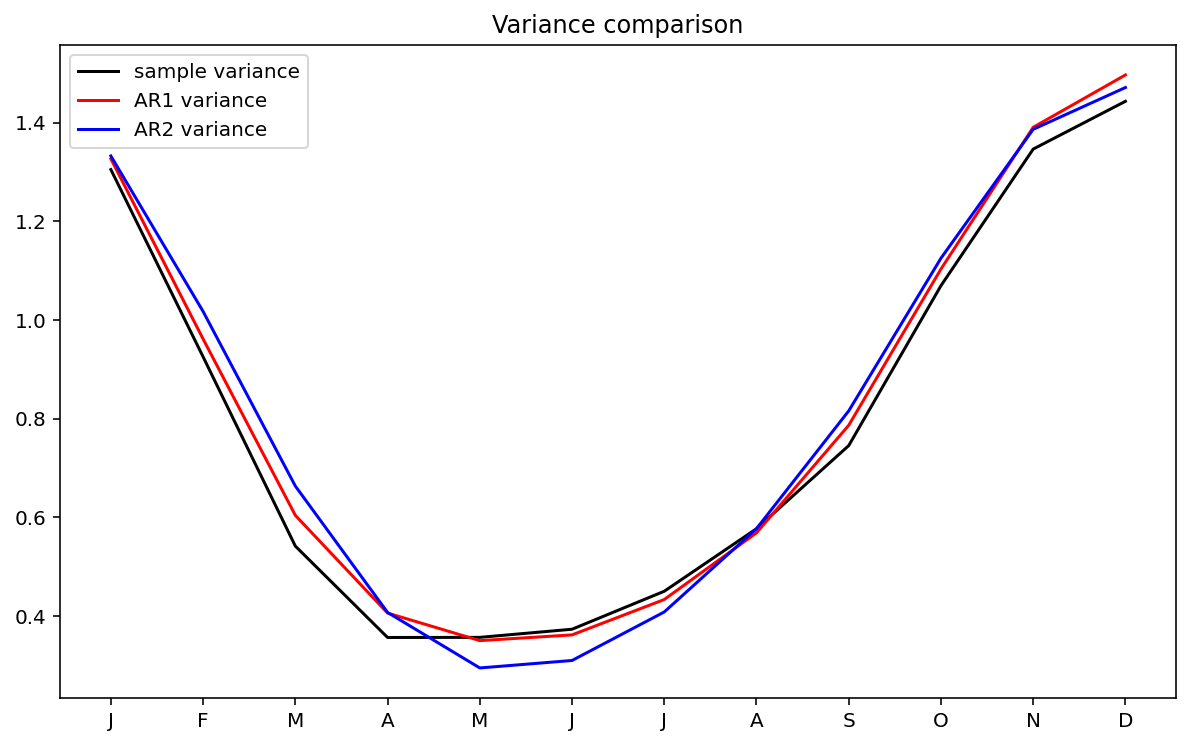

In [34]:
fig, ax = plt.subplots(figsize =(10, 6)) 
ax.plot(sample_var, 'k', label='sample variance')
ax.plot(AR1_var, 'r', label='AR1 variance')
ax.plot(AR2_var, 'b', label='AR2 variance')
ax.set_title('Variance comparison')
ax.set_xticks(np.arange(0,12));
ax.set_xticklabels(m_str);
ax.legend();

Compare correlation among AR1, AR2, and sample:

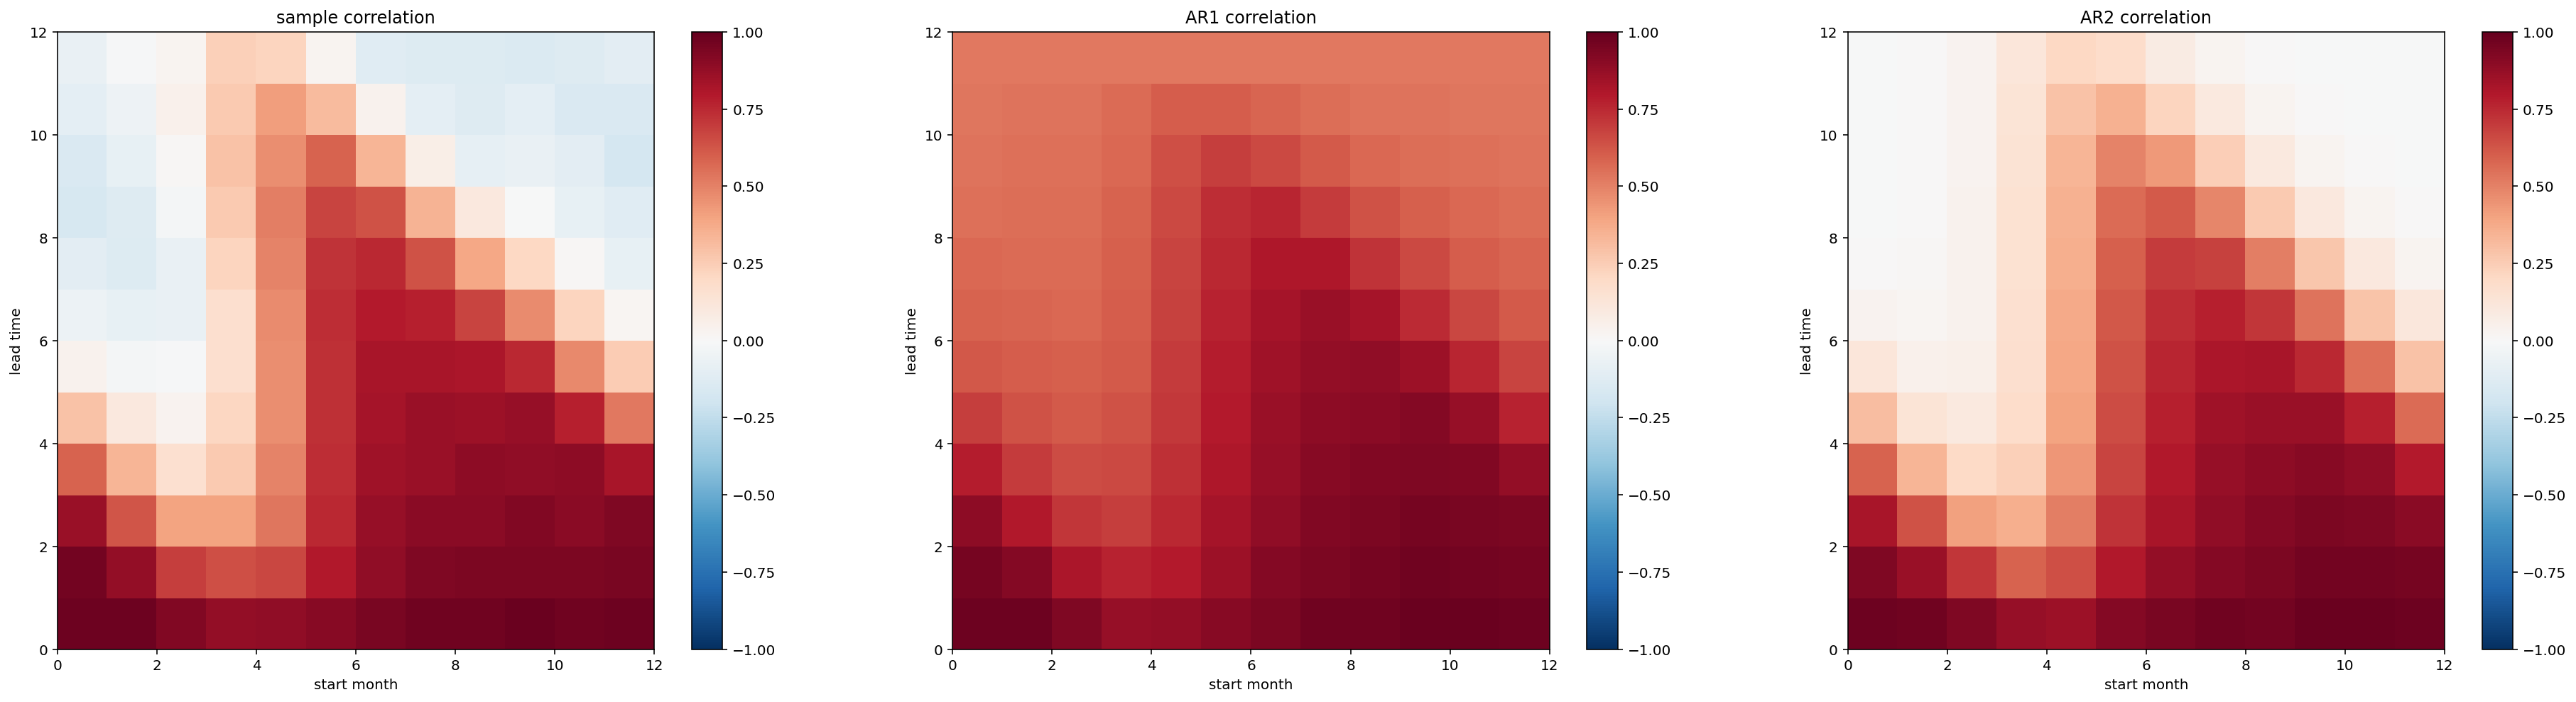

In [37]:
fig, ax = plt.subplots(1,3, figsize = (32, 8))

g = ax[0].pcolormesh(sample_cc, vmin = -1, vmax = 1, cmap = 'RdBu_r')
ax[0].set_xlabel('start month')
ax[0].set_ylabel('lead time');
ax[0].set_title('sample correlation')
plt.colorbar(g, ax = ax[0]);

g = ax[1].pcolormesh(AR1_cc, vmin = -1, vmax = 1, cmap = 'RdBu_r')
ax[1].set_xlabel('start month')
ax[1].set_ylabel('lead time')
ax[1].set_title('AR1 correlation')
plt.colorbar(g, ax = ax[1]);

g = ax[2].pcolormesh(AR2_cc, vmin = -1, vmax = 1, cmap = 'RdBu_r')
ax[2].set_xlabel('start month')
ax[2].set_ylabel('lead time')
ax[2].set_title('AR2 correlation')
plt.colorbar(g, ax = ax[2]);

### Conclusions

1. When comparing the variance among sample, AR1, and AR2, AR1 and AR2 model both give a rather close variance fit to the sample variance. But AR1 model seems to fit to sample variance sightly better than AR2.

2. When it comes to correlation comparison, AR1 and AR2 model have both captured the main pattern of sample correlation such as spring prediction barrier. However, for longer lead time, correlation from AR2 model is much closer to the sample correlation than AR1 model. AR2 model is able to give correlation near 0 for longer lead time as the sample correlation. In contrast, this is not achieved by AR1.

3. Overall, by introducing extra previous time step information to construct AR2 model can further improve Nino 3.4 fitting performance especially for correlation modeling.

### References

[1] Jin, Y., Liu, Z., He, C., & Zhao, Y. (2021). On the Formation Mechanism of the Seasonal Persistence Barrier, Journal of Climate, 34(2), 479-494. 

[2] Yang, Q. Homework 8. https://github.com/Top129/apma4990-qy2216/blob/master/apma-4990-hw-08.ipynb